# Coverage of MultiPLIER LV

The goal of this notebook is to examine why genes were found to be generic. Specifically, this notebook is trying to answer the question: Are generic genes found in more multiplier latent variables compared to specific genes?

The PLIER model performs a matrix factorization of gene expression data to get two matrices: loadings (Z) and latent matrix (B). The loadings (Z) are constrained to aligned with curated pathways and gene sets specified by prior knowledge [Figure 1B of Taroni et. al.](https://www.cell.com/cell-systems/pdfExtended/S2405-4712(19)30119-X). This ensure that some but not all latent variables capture known biology. The way PLIER does this is by applying a penalty such that the individual latent variables represent a few gene sets in order to make the latent variables more interpretable. Ideally there would be one latent variable associated with one gene set unambiguously.

While the PLIER model was trained on specific datasets, MultiPLIER extended this approach to all of recount2, where the latent variables should correspond to specific pathways or gene sets of interest. Therefore, we will look at the coverage of generic genes versus specific genes across these MultiPLIER latent variables.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import random
import pandas as pd
import seaborn as sns

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from ponyo import utils
from generic_expression_patterns_modules import process

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [3]:
# Get data directory containing gene summary data
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
data_dir = os.path.join(base_dir, "human_general_analysis")

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

In [4]:
# Output file
output_figure_filename = "LV_coverage.svg"

## Get gene data

Get generic and specific genes based on simulated gene ranking
Use http://localhost:8888/edit/human_general_analysis/gene_ranking_log2FoldChange.svg as a guide

* Generic genes >= 10000 (Having a high rank indicates that these genes are consistently changed across simulated experiments.)
* Specific genes: simulated rank < 5000 (Having a low rank indicates that these genes are not consistently changed across simulated experiments. It could also indicate genes that are consistently unchanged.)

In [5]:
# Get all gene summary file paths
ls_data_files = process.get_gene_summary_files(data_dir)

In [6]:
generic_threshold = 10000
specific_threshold = 5000
ls_genes_out = process.get_generic_specific_genes(ls_data_files, generic_threshold, specific_threshold)

Reading data for /home/alexandra/Documents/Repos/generic-expression-patterns/human_general_analysis/generic_gene_summary_SRP012656_run2.tsv
(17754, 10)
No. of specific DEGs: 0
No. of generic DEGs: 4067
Reading data for /home/alexandra/Documents/Repos/generic-expression-patterns/human_general_analysis/generic_gene_summary_SRP012656_run4.tsv
(17754, 10)
No. of specific DEGs: 15
No. of generic DEGs: 4052
Reading data for /home/alexandra/Documents/Repos/generic-expression-patterns/human_general_analysis/generic_gene_summary_SRP012656_run3.tsv
(17754, 10)
No. of specific DEGs: 1
No. of generic DEGs: 4066
Reading data for /home/alexandra/Documents/Repos/generic-expression-patterns/human_general_analysis/generic_gene_summary_SRP012656.tsv
(17754, 10)
No. of specific DEGs: 2
No. of generic DEGs: 4065


## Get LV data and filter

In [7]:
# Load multiplier models
# Converted formatted pickle files (loaded using phenoplier environment) from
# https://github.com/greenelab/phenoplier/blob/master/nbs/01_preprocessing/005-multiplier_recount2_models.ipynb
# into .tsv files
# Raw data was downloaded from https://figshare.com/articles/recount_rpkm_RData/5716033/4
multiplier_model_summary = pd.read_csv("multiplier_model_summary.tsv", sep="\t", index_col=0, header=0)
multiplier_model_z = pd.read_csv("multiplier_model_z.tsv", sep="\t", index_col=0, header=0)

In [8]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


In [9]:
# Only select LVs that are signficantly associated with some pathways or gene set (i.e. FDR < 0.05)
multiplier_model_z_processed = process.process_multiplier_model_z(multiplier_model_z, multiplier_model_summary)

In [10]:
multiplier_model_z_processed.head()

,LV1,LV2,LV3,LV4,LV7,LV8,LV10,LV11,LV12,LV13,...,LV953,LV954,LV960,LV962,LV964,LV975,LV976,LV977,LV985,LV986
GAS6,0.000000,0.0,0.039438,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.010517,...,0.000000,0.071876,0.0,0.001723,0.000000,0.0,0.000000,0.000000,0.0,0.000000
MMP14,0.000000,0.0,0.000000,0.0,0.0,0.004904,2.423595,0.029450,0.000000,0.000000,...,0.782420,0.005874,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.014978
DSP,0.000000,0.0,0.000000,0.0,0.0,0.005718,0.000000,0.002028,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.007125,0.0,0.039673,0.008547,0.0,0.000000
MARCKSL1,0.305212,0.0,0.000000,0.0,0.0,0.000000,0.149471,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.541018,0.000000,0.0,0.000000
SPARC,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.014014,0.010638,1.461908,0.000000,...,0.234755,0.000000,0.0,0.306096,0.000000,0.0,0.000000,0.000000,0.0,0.122417


## Quick looks at the data

In [11]:
# Get a rough sense for how many genes contribute to a given LV
# (i.e. how many genes have a value > 0 for a given LV)
(multiplier_model_z > 0).sum().sort_values(ascending=True)

LV37      174
LV935     282
LV912     299
LV45      401
LV817     414
LV921     498
LV61      680
LV819    1065
LV556    1159
LV13     1426
LV730    1446
LV36     1459
LV249    1510
LV847    1522
LV540    1534
LV12     1563
LV14     1603
LV29     1632
LV5      1668
LV759    1728
LV118    1735
LV536    1793
LV59     1797
LV245    1812
LV42     1831
LV11     1832
LV234    1843
LV765    1852
LV252    1857
LV149    1864
         ... 
LV687    3709
LV282    3715
LV9      3717
LV966    3725
LV367    3732
LV636    3734
LV476    3739
LV940    3747
LV526    3754
LV478    3754
LV974    3761
LV732    3779
LV55     3806
LV835    3910
LV379    3953
LV625    3993
LV607    4015
LV74     4025
LV229    4094
LV976    4128
LV395    4220
LV70     4280
LV987    4285
LV739    4441
LV889    4471
LV841    4504
LV516    4520
LV984    4605
LV915    4640
LV830    5496
Length: 987, dtype: int64

In [12]:
# One off just to get a sense for how many genes are being compared
# Filter genes to only use those shared between our analysis and multiplier
# Check overlap between multiplier genes and our genes
multiplier_genes = list(multiplier_model_z.index)
our_genes = list(pd.read_csv(ls_data_files[0], sep="\t", index_col=0, header=0).index)
shared_genes = set(our_genes).intersection(multiplier_genes)

print(len(our_genes))
print(len(shared_genes))

17754
6374


## Gene coverage of LV

1185 0
1179 6
1184 1
1184 1


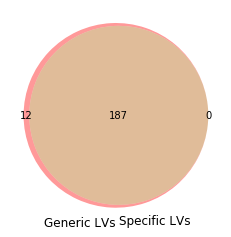

In [13]:
generic_cov_ls = []
specific_cov_ls = []

for ifile in range(len(ls_data_files)):
    generic_genes = ls_genes_out[ifile][0]
    specific_genes = ls_genes_out[ifile][1]
    
    # Only include those genes that are in multiplier otherwise will get NAs
    generic_genes_processed, specific_genes_processed = process.process_generic_specific_gene_lists(
        generic_genes, 
        specific_genes, 
        multiplier_model_z_processed
    )
    print(len(generic_genes_processed), len(specific_genes_processed))
    
    generic_cov_i, specific_cov_i = process.get_LV_coverage(
        generic_genes_processed,
        specific_genes_processed,
        multiplier_model_z_processed
    )
    
    generic_cov_ls += list(generic_cov_i)
    specific_cov_ls += list(specific_cov_i)
    
from matplotlib_venn import venn2
venn2([set(generic_cov_ls), set(specific_cov_ls)],
      set_labels=("Generic LVs", "Specific LVs")
     )

In [14]:
# Create table of unique generic LVs, unique specific LVs, shared LVs
process.create_LV_df(generic_cov_ls, specific_cov_ls, multiplier_model_summary)

No LVs in group: specific_only


In [15]:
# Find the number of generic and specific genes that have a nonzero contribution to LV
generic_cov = []
specific_cov = []
num_significant_LVs = multiplier_model_z_processed.shape[1]

for ifile in range(len(ls_data_files)):
    generic_genes = ls_genes_out[ifile][0]
    specific_genes = ls_genes_out[ifile][1]
    
    # Only include those genes that are in multiplier otherwise will get NAs
    generic_genes_processed, specific_genes_processed = process.process_generic_specific_gene_lists(
        generic_genes, 
        specific_genes, 
        multiplier_model_z_processed
    )
    print(len(generic_genes_processed), len(specific_genes_processed))
    
    generic_cov_i, specific_cov_i = process.get_LV_coverage(
        generic_genes_processed,
        specific_genes_processed,
        multiplier_model_z_processed
    )
    
    generic_cov.append(len(generic_cov_i)/num_significant_LVs)
    specific_cov.append(len(specific_cov_i)/num_significant_LVs)
    
gene_cov = pd.DataFrame({'Proportion of significantly associated LVs covered': generic_cov + specific_cov,
                         'gene type': ['generic']*len(ls_data_files) + ['specific']*len(ls_data_files) 
                      })

1185 0
1179 6
1184 1
1184 1


[1.0, 1.0, 1.0, 1.0]
[0.0, 0.9246231155778895, 0.34673366834170855, 0.40703517587939697]


Text(0.5, 1.0, 'Coverage of pathway-associated LVs')

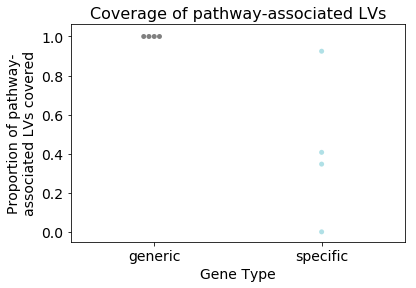

In [16]:
# Plot coverage distribution given list of generic coverage, specific coverage
print(generic_cov)
print(specific_cov)

import textwrap
fig = sns.swarmplot(data=gene_cov, 
                  x='gene type', 
                  y='Proportion of significantly associated LVs covered', 
                  palette=['grey','powderblue'])
fig.set_xlabel("Gene Type",fontsize=14)
fig.set_ylabel(textwrap.fill("Proportion of pathway-associated LVs covered", width=30),fontsize=14)
fig.tick_params(labelsize=14)
fig.set_title("Coverage of pathway-associated LVs", fontsize=16)

Its not surprising that there was more coverage for generic genes vs specific genes because there were many more generic genes found. What if we try to randomly sample a generic gene set that is of the same size as the number of specific genes?

In [17]:
# Randomly generate generic gene list that is the same size as specific gene list
# Re-run coverage analysis
# Find the number of generic and specific genes that have a nonzero contribution to LV
generic_cov_matched = []
specific_cov_matched = []
num_significant_LVs = multiplier_model_z_processed.shape[1]

for ifile in range(len(ls_data_files)):
    generic_genes = ls_genes_out[ifile][0]
    specific_genes = ls_genes_out[ifile][1]
    
    # Only include those genes that are in multiplier otherwise will get NAs
    generic_genes_processed, specific_genes_processed = process.process_generic_specific_gene_lists(
        generic_genes, 
        specific_genes, 
        multiplier_model_z_processed
    )
    
    # Randomly generate generic gene list that is the same size as specific gene list
    generic_genes_processed_subset = random.sample(generic_genes_processed, len(specific_genes_processed))
    print(len(generic_genes_processed_subset), len(specific_genes_processed))
    
    
    generic_cov_i, specific_cov_i = process.get_LV_coverage(
        generic_genes_processed_subset,
        specific_genes_processed,
        multiplier_model_z_processed
    )
    
    generic_cov_matched.append(len(generic_cov_i)/num_significant_LVs)
    specific_cov_matched.append(len(specific_cov_i)/num_significant_LVs)
    
gene_cov_matched = pd.DataFrame({'Proportion of significantly associated LVs covered': generic_cov_matched + specific_cov_matched,
                         'gene type': ['generic']*len(ls_data_files) + ['specific']*len(ls_data_files) 
                      })

0 0
6 6
1 1
1 1


[0.0, 0.9045226130653267, 0.39195979899497485, 0.3869346733668342]
[0.0, 0.9246231155778895, 0.34673366834170855, 0.40703517587939697]


Text(0.5, 1.0, 'Coverage of pathway-associated LVs')

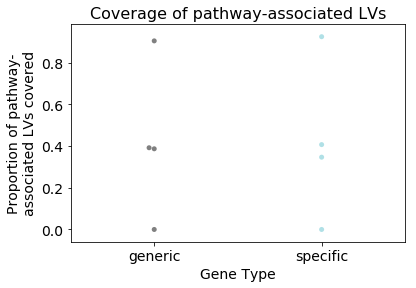

In [18]:
# Plot coverage distribution given list of generic coverage, specific coverage
print(generic_cov_matched)
print(specific_cov_matched)

import textwrap
fig2 = sns.swarmplot(data=gene_cov_matched, 
                  x='gene type', 
                  y='Proportion of significantly associated LVs covered', 
                  palette=['grey','powderblue'])
fig2.set_xlabel("Gene Type",fontsize=14)
fig2.set_ylabel(textwrap.fill("Proportion of pathway-associated LVs covered", width=30),fontsize=14)
fig2.tick_params(labelsize=14)
fig2.set_title("Coverage of pathway-associated LVs", fontsize=16)

In [19]:
# Save plot
fig.figure.savefig(
        output_figure_filename,
        format="svg",
        bbox_inches="tight",
        transparent=True,
        pad_inches=0,
        dpi=300,
    )

**Takeaway:**
* On average, specific genes cover fewer pathway-associated LVs compared to generic genes, which were found to be linked to all pathway-associated LVs.
* Warning: This difference in coverage is not surprising given the fact that there 1-6 specific genes identified compared to the ~1000 generic genes found.
* Some of the LVs that were only found to have generic genes (see [table](generic_only_LV_summary.tsv)) include mainly immune response pathways (monocytes, mast cell activation), wound healing (collagen formation), cell signaling (focal adhesion, integrin1) 

**Overall, it looks like generic genes are associated with many pathways, acting as *gene hubs*, which is why they are "generic"**